In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Documents/eth_courses/notebooks/control`


In [941]:
using ModelingToolkit, DifferentialEquations
using GLMakie
using ForwardDiff

## Plant

In [1185]:
@variables t
D = Differential(t)

# first order system

function Plant(;name)
    sts = @variables (x(t))[1:2, 1:1]=0 (y(t))[1:2]=0 u(t)=0

    A = [0 1; 0 0];
    B = [0;1];
    
    eqn1 = D.(x) ~ A*x + B*u

    eqn2 = y .~ x
    
    eqns = vcat(eqn1, eqn2)
    
    ODESystem(eqns, t; name)
end

Plant (generic function with 1 method)

## Controller

### Zero order hold for digital controller

In [1192]:
# force control input to be constant over sampling time, actual control law applied inside callback
function Controller_Zero_Order_Hold(;name)
    sts = @variables u(t)=0  (r(t))[1:2]=0

    eqn1 = D(u) ~ 0 
    eqn2 = D.(r) .~ 0 

    eqns = vcat(eqn1, eqn2)
    
    ODESystem(eqns, t; name)
end

Controller_Zero_Order_Hold (generic function with 1 method)

In [1193]:
@named controller = Controller_Zero_Order_Hold()

Model controller with 3 equations
States (3):
  u(t) [defaults to 0]
  (r(t))[1] [defaults to 0]
  (r(t))[2] [defaults to 0]
Parameters (0):

### Digital controller

In [1194]:
function digital_controller(int; controller_params=controller_params)

    # parameters
    kp, kd = controller_params.kp, controller_params.kd

    # # get the error term from feedback system
    # error = prob.f.observed(feedback.e, int.u, int.p, int.t)

    # get plant output
    y = prob.f.observed(plant.y, int.u, int.p, int.t)

    # get reference 
    r = reference_generator(int.t)
    r_dot = ForwardDiff.derivative(reference_generator, int.t)
    
    error = r -  y[1]
    error_dot = r_dot -  y[2]

    # compute the control action 
    u = kp * error +  kd * error_dot

    # find index of variable controller.u in the state vector
    controller_index = indexof(controller.u, states(sys))
    r_index = indexof(controller.r[1], states(sys))
    

    # set the control input
    int.u[controller_index] = u
    int.u[r_index: r_index+1] = [r, r_dot]
end

digital_controller (generic function with 2 methods)

## Reference generator

In [1195]:
function reference_generator(t)
    return sin(t)
end

reference_generator (generic function with 2 methods)

## System building

In [1196]:
@named plant = Plant()
@named controller = Controller_Zero_Order_Hold()
@named feedback = Feedback()

eqn1 = plant.u ~ controller.u
# eqn2 = feedback.y .~ plant.y
# eqn3 = controller.e .~ feedback.e
# eqn4 = feedback.r .~ controller.r

eqns = vcat(eqn1)

# connect the subsystems
@named model = ODESystem(eqns,
    systems=[plant, controller])

sys = structural_simplify(model)

indexof(sym,syms) = findfirst(isequal(sym),syms)

indexof (generic function with 1 method)

## Simulation

In [1197]:
# controller parameters
controller_params = (;kp=0.5, kd=15.5);

control_callback = PeriodicCallback(digital_controller, 0.01, initial_affect=true)

# sim parameters
tspan = (0.0, 10.0)

prob = ODEProblem(sys, [], tspan) 
@time sol = solve(prob, Tsit5(); callback=control_callback);

  1.150719 seconds (669.74 k allocations: 45.266 MiB, 4.40% gc time)


### Plotting

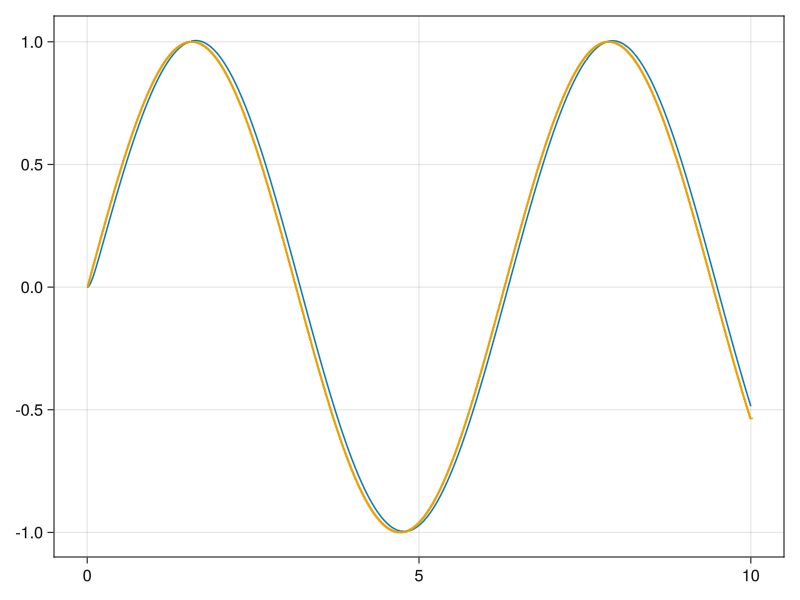

GLMakie.Screen(...)

In [1198]:
fig = Figure()
ax = Axis(fig[1, 1])

lines!(ax, sol.t, sol[plant.y[1]])

#lines!(ax, sol.t, sol[controller.u])
lines!(ax, sol.t, sol[controller.r[1]])

display(fig)